In [7]:
import pandas as pd
import nltk
import re

In [8]:
stopwords = nltk.corpus.stopwords.words('english')

In [9]:
from nltk.stem.snowball import EnglishStemmer
stemmer = EnglishStemmer()

In [10]:
from nltk.tokenize import TreebankWordTokenizer, SpaceTokenizer
tokenizer = TreebankWordTokenizer()

In [11]:
tokenizer.tokenize("Hello, My Name i`s Guy (Really!)")

['Hello', ',', 'My', 'Name', 'i`s', 'Guy', '(', 'Really', '!', ')']

In [12]:
def tokenize_only(text):
    tokens = tokenizer.tokenize(text)
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    
    return filtered_tokens

def tokenize_and_stem(text):
    tokens = tokenize_only(text)
    stems = map(stemmer.stem, tokens)
    return stems

In [13]:
tokenize_and_stem("Hello, My Name is Guy (Really!)")

[u'hello', 'my', u'name', 'is', u'guy', u'realli']

Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized. 

In [14]:
df = pd.read_csv('../data/wiki/wiki.csv.gz', encoding='utf8', index_col=None)

In [15]:
df['text'] = df.text.str[:3000]

In [16]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for doc_text in df.text:
    allwords_stemmed = tokenize_and_stem(doc_text) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(doc_text)
    totalvocab_tokenized.extend(allwords_tokenized)

In [19]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [20]:
vocab_frame.head(10)

,words
may,may
refer,refer
to,to
number,number
the,the
integ,integer
between,between
and,and
year,year
a,a


In [21]:
len(vocab_frame)

358716

## Tf-idf and document similarity

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.01, min_df=3, 
                                   stop_words='english',
                                   tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(df.text)

print(tfidf_matrix.shape)

Wall time: 12.9 s
(835, 10574)


In [25]:
terms = tfidf_vectorizer.get_feature_names()

In [26]:
len(vocab_frame)

358716

In [27]:
terms = tfidf_vectorizer.get_feature_names()

In [28]:
idx = 1000
terms[idx]

u'barn'

In [29]:
terms[2001]

u'concep t'

In [30]:
vocab_frame.ix[terms[idx]].head(5)

,words
barn,Barnes
barn,Barnes
barn,Barne
barn,Barnes
barn,Barnes


## Lets cluster!

In [31]:
from sklearn.cluster import KMeans

num_clusters =30

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 1.44 s


In [32]:
len(clusters)

835

## But what did we get?

In [33]:
clustered = df.join(pd.DataFrame({'cluster': clusters}))

In [34]:
clustered.head()

,name,text,cluster
0,0,"0 may refer to: 0 (number) , the integer b...",20
1,11.22.63,11.22.63 is an American science fiction ...,9
2,2016,2016 has been designated as: Inte...,8
3,4chan,4chan is an English-language image...,24
4,8chan,"8chan, also called Infinitechan, is a...",28


In [35]:
km.cluster_centers_

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00282989,  0.        ,  0.01752607, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00734043,  0.        ,  0.        , ...,  0.00248845,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [36]:
order_centroids = km.cluster_centers_.argsort()

In [37]:
order_centroids

array([[    0,  6917,  6918, ...,  4107,  1690,   898],
       [ 5286,  6824,  6825, ...,  1018,  7370,  4067],
       [ 5286,  6831,  6832, ...,  6916,  3260,  6915],
       ..., 
       [    0,  6938,  6940, ...,  2304, 10567,  3957],
       [    0,  6859,  6860, ...,  8891,  5964, 10326],
       [    0,  6950,  6951, ...,  1810,  9918,  6581]], dtype=int64)

In [38]:
term_words = vocab_frame.ix[terms[idx]]

In [39]:
term_words['words'].value_counts().keys()[0]

u'Barnes'

In [40]:
cluster_names = []

for cluster_centeroids in order_centroids:
    words = []
    for ind in cluster_centeroids[-6:]:
        term_words = vocab_frame.ix[terms[ind].split(' ')]
        
        best_word = term_words['words'].value_counts().keys()[0]
        
        words.append(best_word)
        
    cluster_names.append(', '.join(words))

In [41]:
cluster_names

[u'Republican, Julius, Senate, Hamlet, Cicero, Augustus',
 u'Eminem, punk, band, bassist, rabbit, guitar',
 u"Aristotle, ontology, metaphysics, 's, epistemology, Plato",
 u'psychologist, Netflix, Kosovo, schizophrenia, person, benzodiazepines',
 u'ether, methamphetamine, transgender, morphine, serotonin, amphetamine',
 u'Portugal, Latvia, Tunisia, Greenland, Finland, Norway',
 u'Nunavut, leopard, Uganda, Nile, Tanzania, Kenya',
 u'erosion, allotrope, nitrogen, aluminium, copper, sand',
 u'morning, sanctions, bin, Qatar, Afghan, sharia',
 u'Premis, Manhattan, algorithm, series, TV, syndicated',
 u'Michigan, Philadelphia, Boston, Massachusetts, Oregon, Colorado',
 u'Mali, caffeine, calculus, glucose, maize, Nigeria',
 u'Hollywood, Volkswagen, Bengal, bullying, Compton, gang',
 u'pig, pH, shark, horses, whale, elephants',
 u'Viking, Vancouver, eugenics, Guyana, Walmart, Seattle',
 u'Anthrax, cough, Panama, Pornhub, syphilis, pneumonia',
 u'Venus, Neptune, bisexual, Moses, Amsterdam, Hulk'

In [44]:
clustered['cluster_name'] =clustered.cluster.map(lambda cluster: cluster_names[cluster])

In [45]:
clustered.head(60)

,name,text,cluster,cluster_name
0,0,"0 may refer to: 0 (number) , the integer b...",20,"HDMI, USB, processor, connector, iPhone, REDIRECT"
1,11.22.63,11.22.63 is an American science fiction ...,9,"Premis, Manhattan, algorithm, series, TV, synd..."
2,2016,2016 has been designated as: Inte...,8,"morning, sanctions, bin, Qatar, Afghan, sharia"
3,4chan,4chan is an English-language image...,24,"film, appeal, Awards, 4chan, Burlesque, 's"
4,8chan,"8chan, also called Infinitechan, is a...",28,"X-Force, Batman, Crusade, Spider-Man, mutants,..."
5,Aaliyah,"Aaliyah Dana Haughton ( ; January 16,...",24,"film, appeal, Awards, 4chan, Burlesque, 's"
6,ABBA,ABBA (stylised ᗅᗺᗷᗅ ; ) were a Swed...,1,"Eminem, punk, band, bassist, rabbit, guitar"
7,Abraham,"Abraham ( ; , ), originally Abra...",23,"Lebanon, Mauritius, eternal, Nepal, Hinduism, ..."
8,Achilles,Achilles and the Nereid Cymothoe: Attic ...,18,"Moscow, ROC, 's, Taiwan, prefecture, samurai"
9,Adderall,Adderall is a co mbination drug con...,4,"ether, methamphetamine, transgender, morphine,..."


In [46]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [47]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [48]:
import seaborn as sns

In [49]:
#set up colors per clusters using a dict
cluster_colors = sns.color_palette(n_colors=len(clusters))


In [50]:
%matplotlib inline

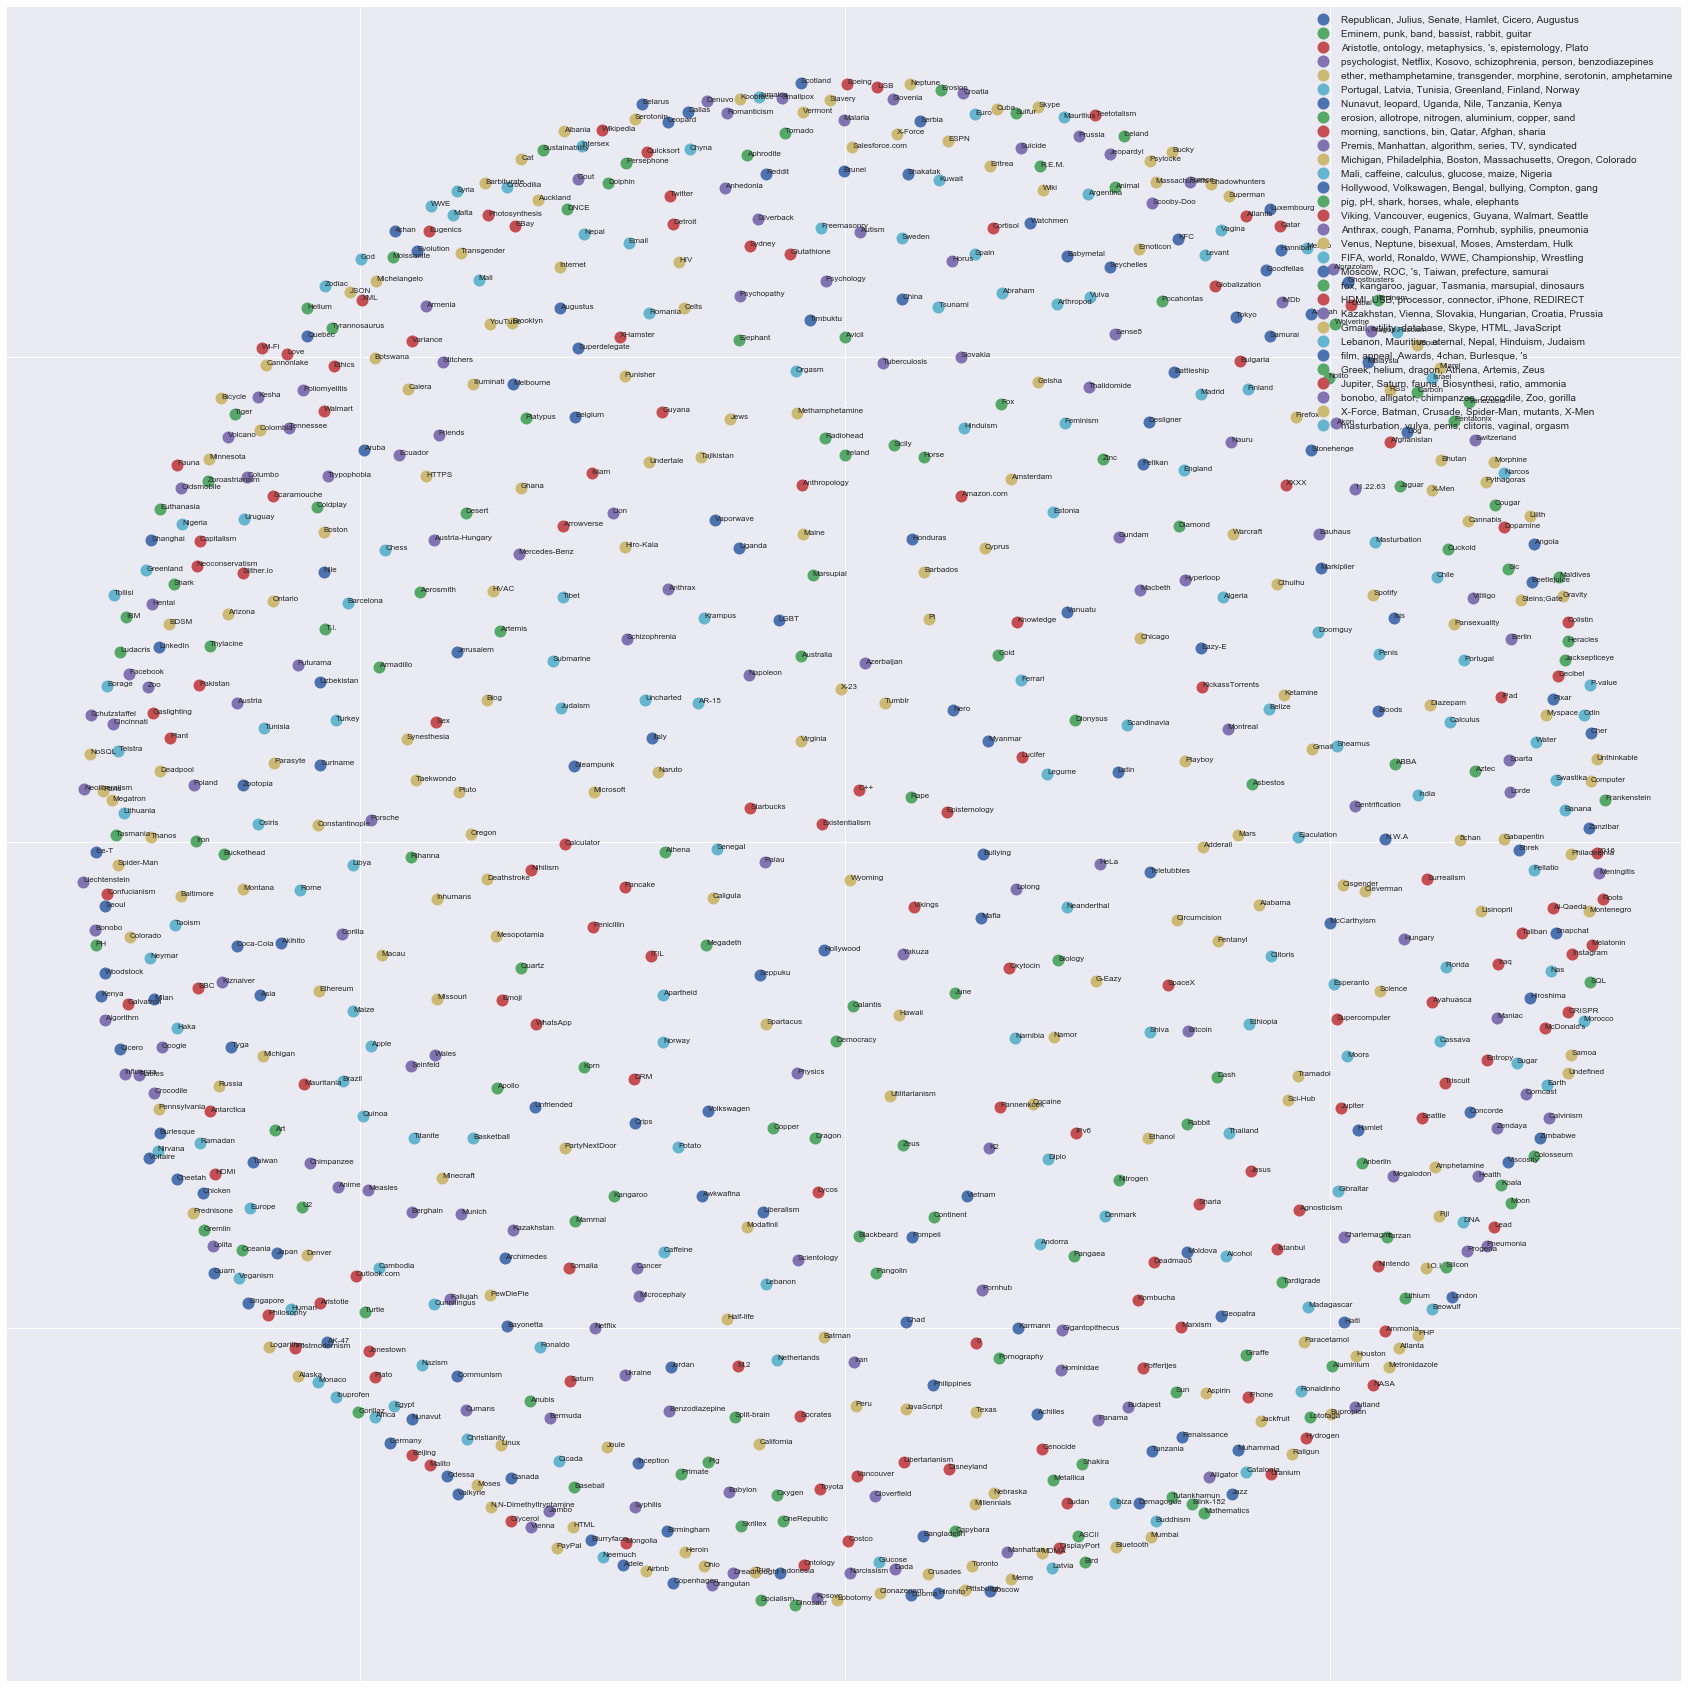

In [51]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=df.name)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(30, 30)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
#plt.show() #show the plot

#uncomment the below to save the plot if need be
plt.savefig('clusters_small_noaxes1.png', dpi=300)